In [1]:
code_file= 'sum.c'

In [2]:
compatible_flags = [
    '-fauto-inc-dec', '-fbranch-count-reg', '-fcombine-stack-adjustments', '-fcompare-elim',
    '-fcprop-registers', '-fdce', '-fdefer-pop', '-fdelayed-branch', '-fdse', '-fforward-propagate',
    '-fguess-branch-probability', '-fif-conversion', '-fif-conversion2', '-finline-functions-called-once',
    '-fipa-modref', '-fipa-profile', '-fipa-pure-const', '-fipa-reference', '-fipa-reference-addressable',
    '-fmerge-constants', '-fmove-loop-invariants', '-fomit-frame-pointer', '-freorder-blocks', '-fshrink-wrap',
    '-fshrink-wrap-separate', '-fsplit-wide-types', '-fssa-backprop', '-fssa-phiopt', '-ftree-bit-ccp',
    '-ftree-ccp', '-ftree-ch', '-ftree-coalesce-vars', '-ftree-copy-prop', '-ftree-dce', '-ftree-dominator-opts',
    '-ftree-dse', '-ftree-forwprop', '-ftree-fre', '-ftree-phiprop', '-ftree-pta', '-ftree-scev-cprop', '-ftree-sink',
    '-ftree-slsr', '-ftree-sra', '-ftree-ter', '-funit-at-a-time', '-falign-functions', '-falign-jumps', '-falign-labels',
    '-falign-loops', '-fcaller-saves', '-fcode-hoisting', '-fcrossjumping', '-fcse-follow-jumps', '-fcse-skip-blocks',
    '-fdelete-null-pointer-checks', '-fdevirtualize', '-fdevirtualize-speculatively', '-fexpensive-optimizations',
    '-ffinite-loops', '-fgcse', '-fgcse-lm', '-fhoist-adjacent-loads', '-finline-functions', '-finline-small-functions',
    '-findirect-inlining', '-fipa-bit-cp', '-fipa-cp', '-fipa-icf', '-fipa-ra', '-fipa-sra', '-fipa-vrp',
    '-fisolate-erroneous-paths-dereference', '-flra-remat', '-foptimize-sibling-calls', '-foptimize-strlen',
    '-fpartial-inlining', '-fpeephole2', '-freorder-blocks-algorithm=stc', '-freorder-blocks-and-partition',
    '-freorder-functions', '-frerun-cse-after-loop', '-fschedule-insns', '-fschedule-insns2', '-fsched-interblock',
    '-fsched-spec', '-fstore-merging', '-fstrict-aliasing', '-fthread-jumps', '-ftree-builtin-call-dce',
    '-ftree-loop-vectorize', '-ftree-pre', '-ftree-slp-vectorize', '-ftree-switch-conversion', '-ftree-tail-merge',
    '-ftree-vrp', '-fvect-cost-model=very-cheap', '-fgcse-after-reload', '-fipa-cp-clone', '-floop-interchange',
    '-floop-unroll-and-jam', '-fpeel-loops', '-fpredictive-commoning', '-fsplit-loops', '-fsplit-paths',
    '-ftree-loop-distribution', '-ftree-partial-pre', '-funswitch-loops', '-fvect-cost-model=dynamic',
    '-fversion-loops-for-strides'
]

In [10]:
import numpy as np
import subprocess
import pickle
import os
from collections import deque
import random
import matplotlib.pyplot as plt
from google.colab import files

class CompilerEnv:
    def __init__(self, code_path):
        self.code_path = code_path
        self.flags = compatible_flags
        self.state_space = len(self.flags)
        self.action_space = len(self.flags)
        self.current_state = tuple([0] * self.state_space)

    def reset(self):
        self.current_state = tuple([0] * self.state_space)
        return self.current_state

    def compile_and_measure(self, flags):
        flags_str = ' '.join([self.flags[i] for i, flag in enumerate(flags) if flag])
        compile_command = f"gcc {self.code_path} {flags_str} -o output"
        run_command = "./output"

        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')

            subprocess.run(f"chmod +x output", shell=True)

            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')

            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')

    def step(self, action):
        current_flags = list(self.current_state)
        current_flags[action] = 1 - current_flags[action]
        self.current_state = tuple(current_flags)

        execution_time = self.compile_and_measure(self.current_state)
        reward = -execution_time

        return self.current_state, reward, False

    def render(self):
        print(f"State: {self.current_state}")

class QLearningAgent:
    def __init__(self, state_space, action_space, q_table_file, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0,
                 exploration_decay=0.99, memory_size=100, batch_size=16):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table_file = q_table_file
        self.q_table = self.load_q_table()
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state_actions = self.q_table.get(state, np.zeros(self.action_space))
            action = np.argmax(state_actions)
        return action

    def learn(self, state, action, reward, next_state):
        if state not in self.q_table:
            self.q_table[state] = np.ones(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_space)

        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.lr * (target - predict)
        self.epsilon *= self.epsilon_decay

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state in batch:
            self.learn(state, action, reward, next_state)

    def save_q_table(self):
        with open(self.q_table_file, 'wb') as f:
            pickle.dump(self.q_table, f)
        files.download(self.q_table_file)
        print("Q-table saved.")

    def load_q_table(self):
        if os.path.exists(self.q_table_file):
            with open(self.q_table_file, 'rb') as f:
                print("Q-table loaded.")
                return pickle.load(f)
        else:
            return {}

def train(agent, env, episodes=1000):
    rewards = []  # List to store total rewards per episode

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_rewards = []  # List to store rewards of each step in the episode
        episode_states = []  # List to store states of each step in the episode

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            episode_rewards.append(reward)
            episode_states.append(state)

            if done:
                break

        agent.replay()
        rewards.append(total_reward)  # Append the total reward for this episode

        # Calculate min, max, and average reward
        min_reward = min(episode_rewards)
        max_reward = max(episode_rewards)
        avg_reward = np.mean(episode_rewards)

        # Find the states corresponding to min and max rewards
        min_state = episode_states[episode_rewards.index(min_reward)]
        max_state = episode_states[episode_rewards.index(max_reward)]

        print(f"Episode {episode + 1}/{episodes}, Rewards per episodes: {total_reward}, Min Reward: {min_reward:.50f} (State: {min_state}), Max Reward: {max_reward:.50f} (State: {max_state}), Average Reward: {avg_reward}")

    agent.save_q_table()


    # Plotting the graph with six decimal places
    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), rewards, marker='o', linestyle='-')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Episodes vs. Total Rewards per Episode')

    # Set y-ticks to show 10 decimal places
    plt.ylim(sum(rewards)/len(rewards), 0)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.10f}'))

    plt.grid(True)
    plt.show()

def evaluate(agent, env, episodes=10):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward

            if done:
                break

        print(f"Episode {episode + 1}/{episodes},  Reward per episode : {total_reward}")


Episode 1/1000, Rewards per episodes: -3.3072450000000004, Min Reward: -0.03454399999999999831823416229781287256628274917603 (State: (0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0)), Max Reward: -0.02662300000000000083089091162946715485304594039917 (State: (0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0)), Average Reward: -0.03307245
Episode 2/1000, Rewards per episodes: -3.1745070000000006, Min Reward: -0.0349479999999999998983035

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Q-table saved.


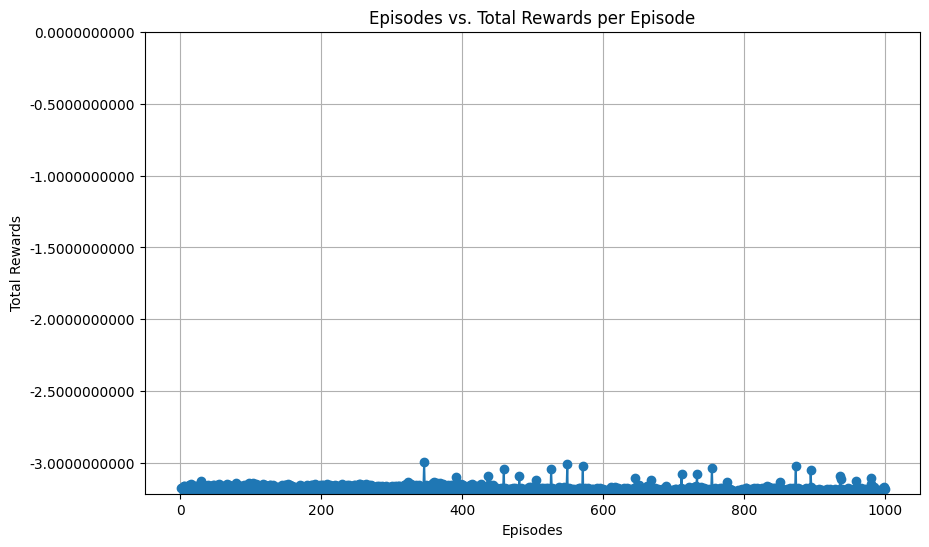

In [11]:
new_code_path = code_file
env = CompilerEnv(new_code_path)
agent = QLearningAgent(env.state_space, env.action_space,'q_table110.pkl')

train(agent, env)